# Imports

In [ ]:
import numpy as np
import pandas as pd
%matplotlib notebook
%matplotlib inline
from matplotlib import pyplot
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
#from keras.datasets import fashion_mnist

# Debugging Libraries
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')

# Data Initialization

I will use the information provided by the Keras library for the Fashion MNIST dataset located over [here](https://github.com/zalandoresearch/fashion-mnist).

## Data Import
In this section, I use the keras library to load the training and testing datasets before creating dataframes out of both sets.

In [ ]:
from keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
x_train.shape

(60000, 28, 28)

In [ ]:
from keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Create the Dataframes
train_df = pd.DataFrame(x_train.reshape((x_train.shape[0], 784)))
test_df = pd.DataFrame(x_test.reshape((x_test.shape[0], 784)))
train_df["label"] = y_train
test_df["label"] = y_test

## Data Functions
I define several functions to provide more utility in producing understandable data.

In [ ]:
# E.G. displayImage(x_train[50,:])
def displayImage(p_npdata):
  if (p_npdata).shape == (784,) or (p_npdata).shape == (28, 28):
    image = p_npdata.reshape((28,28))
    plt.imshow(image)
    plt.show()
  else:
    print("The data passed should be a numpy array of shape (784,) or (28, 28)")

# E.G. displayImageAtIndex(x_train, 50)
def displayImageAtIndex(p_nptable, p_index):
  if p_nptable[p_index, :].shape == (784,) or p_nptable[p_index, :].shape == (28, 28):
    image = p_nptable[p_index, :].reshape((28, 28))
    plt.imshow(image)
    plt.show()
  else:
    print("The data passed at npdata[index] should be a numpy array of shape (784,) or (28, 28)")

def labelName(p_label):
  if p_label == 0:
    return "T-shirt/top"
  elif p_label == 1:
    return "Trouser"
  elif p_label == 2:
    return "Pullover"
  elif p_label == 3:
    return "Dress"
  elif p_label == 4:
    return "Coat"
  elif p_label == 5:
    return "Sandal"
  elif p_label == 6:
    return "Shirt"
  elif p_label == 7:
    return "Sneaker"
  elif p_label == 8:
    return "Bag"
  elif p_label == 9:
    return "Ankle boot"
  else:
    return "Invalid Label"

def distribution(p_x, p_y, p_index):
  fig = plt.figure()
  plt.subplot(2,1,1)
  plt.imshow(p_x[p_index], cmap='gray', interpolation='none')
  plt.title(f"Label: {p_y[p_index]} | {labelName(p_y[p_index])}")
  plt.xticks([])
  plt.yticks([])
  plt.subplot(2,1,2)
  plt.hist(p_x[p_index].reshape(784))
  plt.xlabel("Bit Value")
  plt.ylabel("Pixel Count")
  plt.title("Pixel Value Distribution")


Example usage of the above functions below:

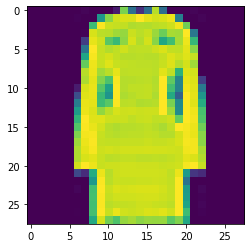

Dress


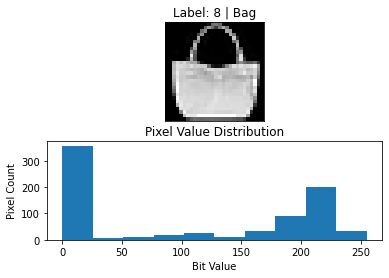

In [ ]:
# This displays the information of the first image.
displayImageAtIndex(x_train, 500)
print(labelName(y_train[500]))
# This displays the distribution of each image.
distribution(x_train, y_train, 100)

## Data Normalization and Split
After importing the data, I vectorize and normalize both the testing and training data before further splitting the training data into training and validation sets. 

Vectorization is a simple process of flattening out each 28 x 28 image data into an array of size 784.

Normalization is a simple division of the max possible value of the features (which is 255).

In [ ]:
# Vectorize
x_train = x_train.reshape((x_train.shape[0], 784))
x_test = x_test.reshape((x_test.shape[0], 784))

# normalize
x_train = x_train / 255
x_test = x_test / 255

# split into normalize
x_train_tr, x_train_va, y_train_tr, y_train_va = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# MLP Implementation

I first implement the cost function class which will contain the functions I need. I use cross-entropy since I will be outputting a classification result.

In [ ]:
class CE:

  def __init__(self, p_activation_fn):
    self.activation_fn = p_activation_fn

  def activation(self, p_z):
    return self.activation_fn.activation(p_z)

  def loss(p_y_true, p_y_pred):
    epsilon = 1e-12
    p_y_pred = np.clip(p_y_pred, epsilon, 1. - epsilon)
    N = p_y_pred.shape[0]
    loss = -np.sum(p_y_true*np.log(p_y_pred+1e-9))/N
    return loss

  @staticmethod
  def prime(p_Y, p_AL):  
    return p_AL - p_Y

  def delta(self, p_y_true, p_y_pred):
    return self.prime(p_y_true, p_y_pred) * self.activation_fn.prime(p_y_pred)

I then define the various activation functions I will be using.

In [ ]:
#Sigmoid Activation Class
class Sigmoid:
  
  @staticmethod
  def activation(p_z):
    return 1 / (1 + np.exp(-p_z))
  
  def prime(p_z):
    return Sigmoid.activation(p_z) * (1 - Sigmoid.activation(p_z))

#Tanh Activation Class
class Tanh:

  @staticmethod
  def activation(p_z):
    return (np.exp(p_z) - np.exp(-p_z)) / (np.exp(p_z) + np.exp(-p_z))

  def prime(p_z):
    return 1 - np.power(Tanh.activation(p_z), 2)

#RELU Activation Class
class RELU:

  def activation(p_z):
    return np.maximum(0, p_z)

  def prime(p_z):
    p_z[p_z<=0] = 0
    p_z[p_z>0] = 1
    return p_z
#Leaky RELU Activation Class
class Leaky_RELU:
  def activation(p_z,a = 0.1):
    return np.where(p_z>0, p_z, a*p_z)

  def prime(p_z,a=0.1):
    p_z[p_z<=0] = a
    p_z[p_z>0] = 1
    return p_z      

# Softmax Activation Class
class Softmax:
  @staticmethod
  def activation(x):
    e = np.exp(x-np.max(x))
    s = np.sum(e, axis=1, keepdims=True)
    return e/s
  
  @staticmethod
  def prime(z):
    return Softmax.activation(z) * Softmax.activation(1-z)

## MLP Class

In [ ]:
class MLP:
  # [Constructor]
  def __init__(self, p_dim, p_activations):

    self.n_layers = len(p_dim)
    self.loss = None
    self.learning_rate = None
    self.w = {}
    self.b = {}
    self.lambd = None
    self.activations = {}

    for i in range(len(p_dim) - 1):
      self.w[i + 1] = np.random.randn(p_dim[i], p_dim[i + 1]) / np.sqrt(p_dim[i])
      self.b[i + 1] = np.zeros(p_dim[i + 1])
      self.activations[i + 2] = p_activations[i]

  # [Function] Forward function, taking us into our gradients
  def forward(self, p_x):

    z = {}
    a = {1: p_x}

    # current layer = i
    # activation layer = i + 1
    for i in range(1, self.n_layers):
      z[i + 1] = a[i].dot(self.w[i]) + self.b[i]
      #z[i + 1] = np.dot(a[i], self.w[i]) + self.b[i]
      a[i + 1] = self.activations[i + 1].activation(z[i + 1])

    return z, a  

  # [Function] Backward function, Determines partial derivative and delta for the output layer.
  def backward(self, p_z, p_a, p_y_true):

    delta = self.loss.delta(p_y_true, p_a[self.n_layers])
    dw = np.dot(p_a[self.n_layers - 1].T, delta)

    update_params = {
      self.n_layers - 1: (dw, delta)
    }

    for i in reversed(range(2, self.n_layers)):
      delta = np.dot(delta, self.w[i].T) * self.activations[i].prime(p_z[i])
      dw = np.dot(p_a[i - 1].T, delta)
      update_params[i - 1] = (dw, delta)

    # Update the weights and biases
    for k, v in update_params.items():
      self._update_w_b(k, v[0], v[1]) 
    
  # [Function] Updates our weights after the gradient descent using L2 Reg
  def _update_w_b(self, index, dw, delta):
    dw += (self.lambd) * self.w[index] 
    self.w[index] -= self.learning_rate * dw
    self.b[index] -= self.learning_rate * np.mean(delta, 0)
  
  # [Function] Fits the model
  # (plot = true): Plots test/train accuracy against number of epoches
  def fit(self, p_x_train, p_y_train, p_x_test, p_y_test, p_epoches, p_batchsize, loss, lambd, learning_rate=1e-3, plot= False):
    
    y_train = np.eye(10)[p_y_train]
    y_test = np.eye(10)[p_y_test]

    # Confirm that we have the same N for x_train and y_train
    if not p_x_train.shape[0] == y_train.shape[0]:
      raise ValueError("Length of x_train and y arrays don't match")
    
    self.loss = loss(self.activations[self.n_layers])
    self.learning_rate = learning_rate
    self.lambd = lambd
    train_log = []
    test_log = []
    losses=[]

    for i in range(p_epoches):
      
      # Shuffle the data
      seed = np.arange(p_x_train.shape[0])
      np.random.shuffle(seed)
      x_ = p_x_train[seed]
      y_ = y_train[seed]

      # loop over minibatches
      for j in range(p_x_train.shape[0] // p_batchsize):
        k = j * p_batchsize
        l = (j + 1) * p_batchsize
        z, a = self.forward(x_[k:l])
        self.backward(z, a, y_[k:l])

      train_log.append(np.mean(self.predict(p_x_train) == np.argmax(y_train,axis = 1)))
      test_log.append(np.mean(self.predict(p_x_test) == np.argmax(y_test,axis = 1)))

      if (i + 1) % 10 == 0:
        _, a = self.forward(p_x_train)
        y_pred = a[self.n_layers]
        losses.append(loss.loss(y_train, y_pred)) 
        
      if plot:
        clear_output()
        print("Epoch", i)
        print("Train accuracy:", train_log[-1])
        print("Test accuracy:", test_log[-1])
        plt.plot(train_log, label = 'train accuracy')
        plt.plot(test_log, label='test accuracy')
        plt.legend(loc = 'best')
        plt.ylabel('Accuracy')
        plt.xlabel('epoches')
        plt.grid()
        plt.show()

    if plot:
        plt.figure()    
        plt.plot((np.arange(len(losses))+1)*10, losses)
        plt.ylabel('Loss')
        plt.xlabel('epoches')
        plt.grid()
        plt.show()
    return train_log , test_log

  def predict(self, x):
    _, a = self.forward(x)
    return np.argmax(a[self.n_layers],axis=1)
        
# func that returns the average accuracies 
def evaluate_acc (True_label,Predicted_label):
    return np.sum(True_label == Predicted_label)/Predicted_label.shape[0]


# K-Fold Cross Validation

In [ ]:
def cross_validation_split(n, n_folds=5):
  #get the number of data samples in each split
  n_val = n // n_folds
  inds = np.random.permutation(n)
  inds = []
  for f in range(n_folds):
    tr_inds = []
    #get the validation indexes
    val_inds = list(range(f * n_val, (f+1)*n_val))
    #get the train indexes
    if f > 0:
      tr_inds = list(range(f*n_val))
    if f < n_folds - 1:
      tr_inds = tr_inds + list(range((f+1)*n_val, n))
    #The yield statement suspends function’s execution and sends a value back to the caller
    # but retains enough state information to enable function to resume where it is left off
    yield tr_inds, val_inds

def kfoldCV(x , y, n_folds , model, lr, lambdaa, n_epoches):
  score_val = np.zeros(n_folds)
  for f, (tr, val) in enumerate(cross_validation_split(x.shape[0], n_folds)):
    train_log, val_log = model.fit(x[tr], y[tr], x[val], y[val], p_epoches=n_epoches, p_batchsize=256, loss=CE,lambd = lambdaa, learning_rate=lr)
    score_val[f] = evaluate_acc(y[val], model.predict(x[val]))
  return score_val, score_val.mean()

# method to get accuracy
def evaluate_acc (Predicted_label, True_label):
  return np.sum(True_label == Predicted_label)/True_label.shape[0]

# Experiments

## 1.1 MLP with no hidden layers

This was the code used to find out the best learning rate:


```
lr = np.array([1e-4, 1e-3, 1e-2, 1e-1, 5e-1])
acc = np.zeros(len(lr))

best_lr = -1
best_acc = -1


# Go over our 4 learning rates
for i in range(len(lr)):
  cur_mlp = MLP((784, 10), (Softmax,))
  cur_acc = kfoldCV(x_train, y_train, n_folds = 5, model = cur_mlp, lr = lr[i], lambdaa = 0, n_epoches = 60)[1]
  acc[i] = cur_acc
  if cur_acc > best_acc:
    best_acc = cur_acc
    best_lr = lr[i]
  print(f'for learning_rate= {lr[i]}  => acc = {cur_acc}, best score = {best_acc}')

print(f'Best Learning Rate: {best_lr}')
plt.title('Accuracy of Learning Rates (0L)')
plt.plot(lr, acc)
plt.ylabel('Accuracy')
plt.xlabel('learning Rate')
plt.grid()
plt.show()
```

I leave it as a code block (and not to be ran) since it takes HOURS to finish.

Our results were:

| Learning Rate | Accuracy |
|---------------|----------|
| 0.0001        | 0.75068  |
| 0.001         | 0.8257   |
| **0.01**         | **0.855**    |
| 0.1           | 0.84818  |
| 0.5           | 0.79205  |

Epoch 99
Train accuracy: 0.8566833333333334
Test accuracy: 0.8381


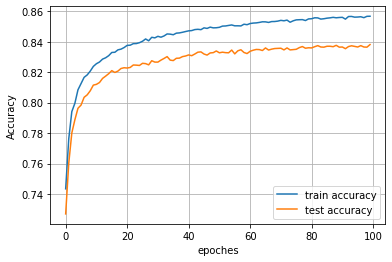

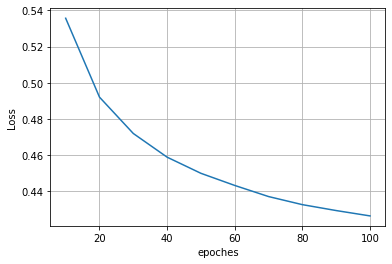

In [ ]:
# Single Training
mlp = MLP((784, 10), (Softmax,))
train_log, val_log = mlp.fit(x_train, y_train, x_test, y_test, p_epoches=100, p_batchsize=256, loss=CE,lambd = 0, learning_rate=1e-2, plot=True)

## 1.2 MLP with 1 hidden layer

This was the code used to find out the best learning rate:


```
lr = np.array([1e-4, 1e-3, 1e-2, 1e-1, 5e-1])
acc = np.zeros(len(lr))

best_lr = -1
best_acc = -1


# Go over our 4 learning rates
for i in range(len(lr)):
  cur_mlp = MLP((784, 128, 10), (RELU, Softmax))
  cur_acc = kfoldCV(x_train, y_train, n_folds = 5, model = cur_mlp, lr = lr[i], lambdaa = 0, n_epoches = 60)[1]
  acc[i] = cur_acc
  if cur_acc > best_acc:
    best_acc = cur_acc
    best_lr = lr[i]
  print(f'for learning_rate= {lr[i]}  => acc = {cur_acc}, best score = {best_acc}')

print(f'Best Learning Rate: {best_lr}')
plt.title('Accuracy of Learning Rates (1L: RELU)')
plt.plot(lr, acc)
plt.ylabel('Accuracy')
plt.xlabel('learning Rate')
plt.grid()
plt.show()
```

I leave it as a code block (and not to be ran) since it takes HOURS to finish.

Our results were:

| Learning Rate | Accuracy |
|---------------|----------|
| 0.0001        | 0.75078  |
| 0.001         | 0.846   |
| 0.01          | 0.8966    |
| **0.1**          | **0.93865**  |
| 0.5           | 0.09565  |

Epoch 99
Train accuracy: 0.9456666666666667
Test accuracy: 0.8803


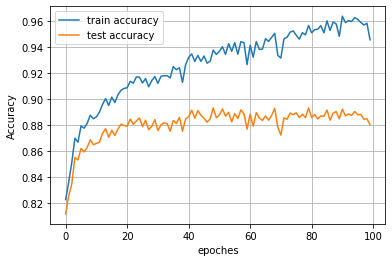

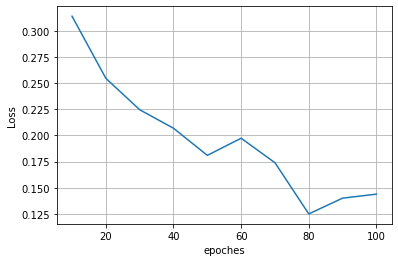

In [ ]:
# Initial training
nn = MLP((784, 128, 10), (RELU, Softmax))
train_log, val_log = nn.fit(x_train, y_train, x_test, y_test, p_epoches=100, p_batchsize=256, loss=CE,lambd = 0, learning_rate=1e-1, plot=True)

## 1.3 MLP with 2 hidden layers

This was the code used to find out the best learning rate:


```
lr = np.array([1e-4, 1e-3, 1e-2, 1e-1, 5e-1])
acc = np.zeros(len(lr))

best_lr = -1
best_acc = -1


# Go over our 4 learning rates
for i in range(len(lr)):
  cur_mlp = MLP((784, 128, 128, 10), (RELU, RELU, Softmax))
  cur_acc = kfoldCV(x_train, y_train, n_folds = 5, model = cur_mlp, lr = lr[i], lambdaa = 0, n_epoches = 60)[1]
  acc[i] = cur_acc
  if cur_acc > best_acc:
    best_acc = cur_acc
    best_lr = lr[i]
  print(f'for learning_rate= {lr[i]}  => acc = {cur_acc}, best score = {best_acc}')

print(f'Best Learning Rate: {best_lr}')
plt.title('Accuracy of Learning Rates (2L: RELU, RELU)')
plt.plot(lr, acc)
plt.ylabel('Accuracy')
plt.xlabel('learning Rate')
plt.grid()
plt.show()
```

I leave it as a code block (and not to be ran) since it takes HOURS to finish.

Our results were:

| Learning Rate | Accuracy |
|---------------|----------|
| 0.0001        | 0.73803  |
| 0.001         | 0.85845   |
| **0.01**         | **0.90889**    |
| 0.1          | 0.8862  |
| 0.5           | 0.09563  |

Epoch 79
Train accuracy: 0.9132
Test accuracy: 0.8799


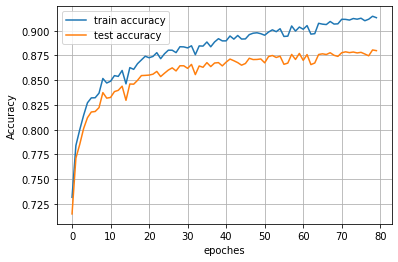

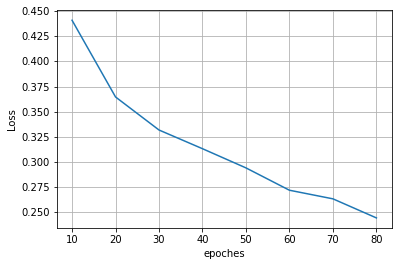

In [ ]:
nn = MLP((784, 128, 128, 10), (RELU, RELU, Softmax))
train_log, val_log = nn.fit(x_train, y_train, x_test, y_test, p_epoches=80, p_batchsize=256, loss=CE,lambd = 0, learning_rate=1e-2, plot=True)

## 2.1 MLP with 2 hidden layers (TanH, TanH RELU)

This was the code used to find out the best learning rate:


```
lr = np.array([1e-4, 1e-3, 1e-2, 1e-1, 5e-1])
acc = np.zeros(len(lr))

best_lr = -1
best_acc = -1


# Go over our 4 learning rates
for i in range(len(lr)):
  cur_mlp = MLP((784, 128, 128, 10), (Tanh, Tanh, Softmax))
  cur_acc = kfoldCV(x_train, y_train, n_folds = 5, model = cur_mlp, lr = lr[i], lambdaa = 0, n_epoches = 60)[1]
  acc[i] = cur_acc
  if cur_acc > best_acc:
    best_acc = cur_acc
    best_lr = lr[i]
  print(f'for learning_rate= {lr[i]}  => acc = {cur_acc}, best acc = {best_acc}')

print(f'Best Learning Rate: {best_lr}')
plt.plot(lr, acc)
plt.title('Accuracy of Learning Rates (2L: Tanh, Tanh)')
plt.ylabel('Accuracy')
plt.xlabel('learning Rate')
plt.grid()
plt.show()
```

I leave it as a code block (and not to be ran) since it takes HOURS to finish.

Our results were:

| Learning Rate | Accuracy |
|---------------|----------|
| 0.0001        | 0.77368  |
| 0.001         | 0.85821   |
| 0.01         | 0.90365   |
| **0.1**         | **0.9544**  |
| 0.5           | 0.80051  |

Epoch 79
Train accuracy: 0.96935
Test accuracy: 0.8955


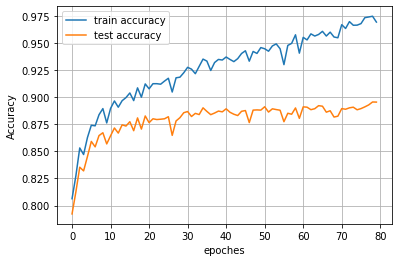

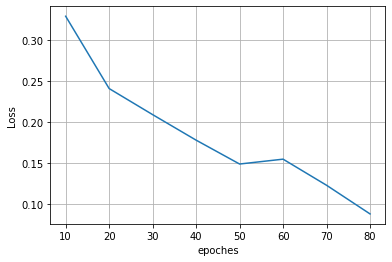

In [ ]:
nn = MLP((784, 128, 128, 10), (Tanh, Tanh, Softmax))
train_log, val_log = nn.fit(x_train, y_train, x_test, y_test, p_epoches=80, p_batchsize=256, loss=CE,lambd = 0, learning_rate=1e-1, plot=True)

##2.2 MLP with 2 hidden layers(Leaky RELU, Leaky RELU)

This was the code used to find out the best learning rate:


```
lr = np.array([1e-2, 1e-1])
acc = np.zeros(len(lr))

best_lr = -1
best_acc = -1

# Go over our 5 learning rates
for i in range(len(lr)):
  cur_mlp = MLP((784, 128, 128, 10), (Leaky_RELU, Leaky_RELU, Softmax))
  cur_acc = kfoldCV(x_train, y_train, n_folds = 5, model = cur_mlp, lr = lr[i], lambdaa = 0, n_epoches = 60)[1]
  acc[i] = cur_acc
  if cur_acc > best_acc:
    best_acc = cur_acc
    best_lr = lr[i]
  print(f'for learning_rate= {lr[i]}  => acc = {cur_acc}, best acc = {best_acc}')

print(f'Best Learning Rate: {best_lr}')
plt.plot(lr, acc)
plt.title('Accuracy of Learning Rates (2L: Leaky_RELU, Leaky_RELU)')
plt.ylabel('Accuracy')
plt.xlabel('learning Rate')
plt.grid()
plt.show()
```

I leave it as a code block (and not to be ran) since it takes HOURS to finish.

Our results were:

| Learning Rate | Accuracy |
|---------------|----------|
| 0.0001        | 0.75042  |
| 0.001         | 0.84876   |
| **0.01**         | **0.8588**   |
| 0.1         | 0.1  |
| 0.5           | 0.1  |

Epoch 79
Train accuracy: 0.8658166666666667
Test accuracy: 0.8409


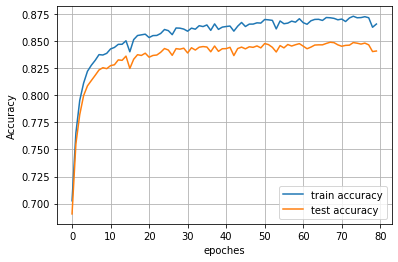

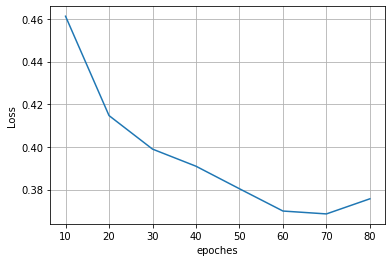

In [ ]:
mlp = MLP((784, 128, 128, 10), (Leaky_RELU, Leaky_RELU, Softmax))
train_log, val_log = mlp.fit(x_train, y_train, x_test, y_test, p_epoches=80, p_batchsize=256, loss=CE,lambd = 0, learning_rate=1e-2, plot=True)

## 3 MLP with 2 hidden layers (L2 Regularization)

L2 Regularization with Λ = 0.3

In [ ]:
nn = MLP((784, 128, 128, 10), (RELU, RELU, Softmax))
train_log, test_log = nn.fit(x_train_tr, y_train_tr, x_train_va, y_train_va, p_epoches=40, p_batchsize=256, loss=CE,lambd = 0.3, learning_rate=0.1, plot=True)

L2 Regularization with Λ = 0.01

In [ ]:
nn = MLP((784, 128, 128, 10), (RELU, RELU, Softmax))
train_log, test_log = nn.fit(x_train_tr, y_train_tr, x_train_va, y_train_va, p_epoches=40, p_batchsize=256, loss=CE,lambd = 0.01, learning_rate=0.1, plot=True)

This was the code used to find out the best learning rate:


```
lr = np.array([1e-2, 1e-1])
lambdaa = np.array([0.3, 0.1, 0.01])
acc = np.zeros((len(lr),len(lambdaa)))

best_lambda = -1
best_lr = -1
best_acc = -1

# Go over our 4 learning rates
for i in range(len(lr)):
  for j in range (len(lambdaa)):
    cur_mlp = MLP((784, 128, 128, 10), (RELU, RELU, Softmax))
    cur_acc = kfoldCV(x_train, y_train, n_folds = 5, model = cur_mlp, lr = lr[i], lambdaa = lambdaa[j], n_epoches = 60)[1]
    acc[i, j] = cur_acc
    if cur_acc > best_acc:
      best_acc = cur_acc
      best_lr = lr[i]
      best_lambda = lambdaa[j]
    print(f'for learning_rate= {lr[i]}, lambda = {lambdaa[j]}  => acc = {cur_acc}, best acc = {best_acc}')
  
print(f'Best Learning Rate: {best_lr}')
print(f'Best Lambda: {best_lambda}')
for i in range (len(lr)):
  plt.plot(lambdaa, acc[i], label = f"Learning Rate: {lr[i]}")

plt.legend(loc='best')
plt.title('Accuracy of Lambda (2L: RELU, RELU)')
plt.ylabel('Accuracy')
plt.xlabel('Lambda')
plt.grid()
plt.show()
```

I leave it as a code block (and not to be ran) since it takes HOURS to finish.

Our results were:

| Learning Rate | Lambda | Accuracy |
|---------------|----------|----------|
| 0.01       | 0.3  | 0.64878  |
| 0.01         | 0.1   |0.7828   |
| **0.01**         | **0.01**   |**0.87892**  |
| 0.1         | 0.3  |0.54813 |
| 0.1           | 0.1  | 0.71645  |
| 0.1           | 0.01  | 0.8455  |

Epoch 79
Train accuracy: 0.88465
Test accuracy: 0.8657


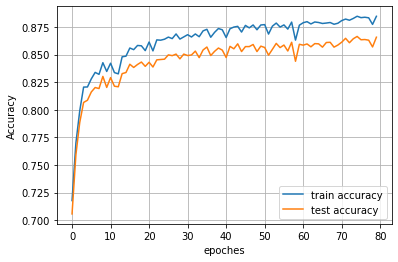

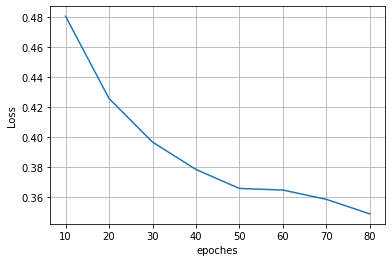

In [ ]:
mlp = MLP((784, 128, 128, 10), (RELU, RELU, Softmax))
train_log, test_log = mlp.fit(x_train, y_train, x_test, y_test, p_epoches=80, p_batchsize=256, loss=CE,lambd = 0.01, learning_rate=0.01, plot=True)

## 4 MLP with 2 hidden layers (Unnormalized)

Epoch 79
Train accuracy: 0.1
Test accuracy: 0.1


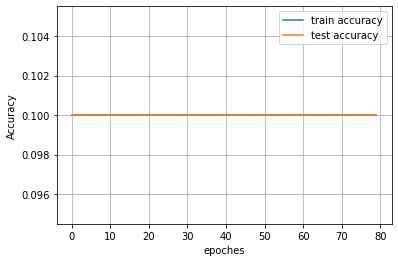

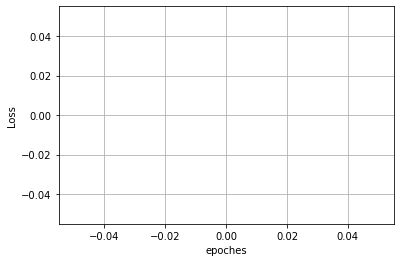

Accuracy on Test0.1


In [ ]:
xun_train = (x_train * 255).astype(int)
xun_test = (x_test * 255).astype(int)

model = MLP((784, 128, 128, 10), (RELU, RELU, Softmax))
train_log, val_log = model.fit(xun_train, y_train, xun_test, y_test, p_epoches=80, p_batchsize=256, loss=CE,lambd = 0, learning_rate=1e-2, plot=True)
print(f"Accuracy on Test{evaluate_acc(model.predict(xun_test), y_test)}")

##5 Convolutional Neural Network (ConvNet) with 2 convolutional and 2 fully connected layers

### Model

In [ ]:
import tensorflow as tf
# TensorFlow ≥2.0 is required
try:
    import tensorflow as tf
except ModuleNotFoundError:
    %pip install -qq tensorflow
    import tensorflow as tf
from tensorflow import keras

assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices("GPU"):
    print("No GPU was detected. DNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelEncoder
from pandas import get_dummies
from keras.utils import to_categorical

In [ ]:
try:
    import imageio
except ModuleNotFoundError:
    %pip install -qq imageio
    import imageio
from IPython import display
import sklearn
from time import time

np.random.seed(0)

try:
    from probml_utils.mnist_helper_tf import *
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    from probml_utils.mnist_helper_tf import *

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 272 kB 30.1 MB/s 
     |████████████████████████████████| 132 kB 74.3 MB/s 
     |████████████████████████████████| 88 kB 8.5 MB/s 
     |████████████████████████████████| 85 kB 5.0 MB/s 
     |████████████████████████████████| 121 kB 70.0 MB/s 
     |████████████████████████████████| 1.6 MB 70.5 MB/s 
     |████████████████████████████████| 83 kB 2.3 MB/s 
     |████████████████████████████████| 1.1 MB 64.1 MB/s 


4422102/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)


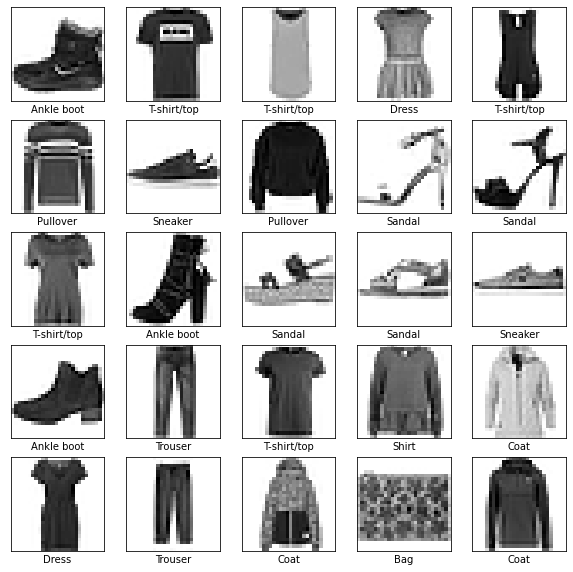

In [ ]:
train_images, target_train, test_images, target_test, class_names = get_dataset(FASHION=True)

# Parse numbers as floats
input_train = train_images.astype('float32')
input_test = test_images.astype('float32')

# Scale data
input_train = input_train / 255
input_test = input_test / 255
print(train_images.shape)
plot_dataset(train_images, target_train, class_names)

In [ ]:
img_width, img_height, img_num_channels = 28, 28, 1
input_shape = (img_width, img_height, img_num_channels)

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 flatten (Flatten)           (None, 36864)             0         
                                                                 
 dense (Dense)               (None, 128)               4718720   
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 4,755,338
Trainable params: 4,755,338
Non-

In [ ]:
batch_size = 256
no_classes = 10
no_epochs = 90
validation_split = 0.2
verbosity = 1

In [ ]:
# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=['accuracy'])

history = model.fit(input_train, target_train,
            batch_size = 50,
            epochs=no_epochs,
            verbose=verbosity,
            validation_split=validation_split)
score = model.evaluate(input_test, target_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Epoch 1/90
960/960 [==============================] - 18s 8ms/step - loss: 0.8083 - accuracy: 0.6949 - val_loss: 0.5753 - val_accuracy: 0.7860
Epoch 2/90
960/960 [==============================] - 5s 5ms/step - loss: 0.5218 - accuracy: 0.8068 - val_loss: 0.4911 - val_accuracy: 0.8172
Epoch 3/90
960/960 [==============================] - 5s 5ms/step - loss: 0.4512 - accuracy: 0.8354 - val_loss: 0.4394 - val_accuracy: 0.8422
Epoch 4/90
960/960 [==============================] - 5s 5ms/step - loss: 0.4121 - accuracy: 0.8480 - val_loss: 0.4057 - val_accuracy: 0.8547
Epoch 5/90
960/960 [==============================] - 5s 5ms/step - loss: 0.3911 - accuracy: 0.8570 - val_loss: 0.3871 - val_accuracy: 0.8553
Epoch 6/90
960/960 [==============================] - 5s 5ms/step - loss: 0.3711 - accuracy: 0.8634 - val_loss: 0.3910 - val_accuracy: 0.8558
Epoch 7/90
960/960 [==============================] - 5s 5ms/step - loss: 0.3548 - accuracy: 0.8669 - val_loss: 0.3724 - val_accuracy: 0.8643
Epoch

##6 MLP implementation

Epoch 39
Train accuracy: 0.8731875
Test accuracy: 0.8621666666666666


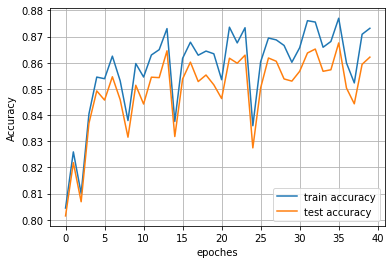

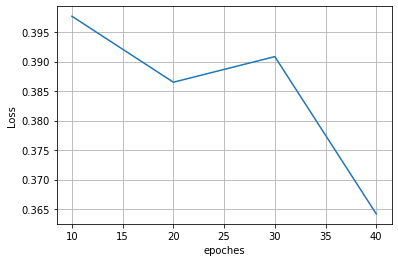

In [ ]:
model = MLP((784, 128, 128, 10), (RELU, RELU, Softmax))
train_log, test_log = model.fit(x_train_tr, y_train_tr, x_train_va, y_train_va, p_epoches=40, p_batchsize=256, loss=CE,lambd = 0.01, learning_rate=0.1, plot=True)

In [ ]:
predicted =model.predict(x_test)
acc = evaluate_acc(y_test,predicted)
print(f"accuracy is {acc}")

accuracy is 0.8534


In [ ]:
p_epoches= [90,110]
learning_rate = [0.1,0.01,0.001]
lamb = [0.1,0.01,0.001]

In [ ]:
for epoch in p_epoches:
  for lr in learning_rate:
    for lam in lamb:
      train_log, test_log = model.fit(x_train_tr, y_train_tr, x_train_va, y_train_va, p_epoches=epoch, p_batchsize=256, loss=CE,lambd = lam, learning_rate=lr, plot=False)
      predicted =model.predict(x_test)
      acc = evaluate_acc(y_test,predicted)
      print(f"accuracy is {acc} for p_epoche {epoch}, learning rate {lr}, lamb{lam}")


accuracy is 0.7148 for p_epoche 90, learning rate 0.1, lamb0.1


# Extra Experiments

In this section, I maintain the same learning rates used in the EXPERIMENTS section, since they are the best ones I have found.

## RELU Variation

### MLP with 1 hidden layer (RELU | 64 Units)

Epoch 99
Train accuracy: 0.9441333333333334
Test accuracy: 0.8835


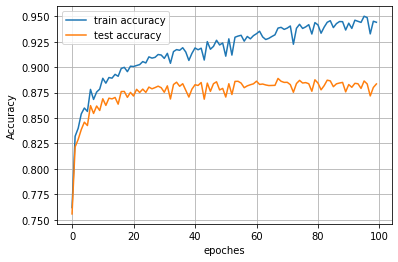

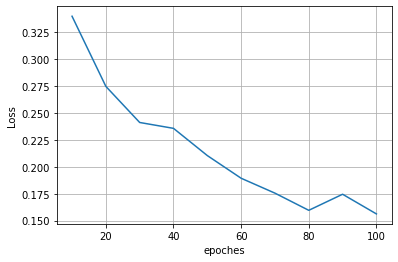

In [ ]:
# Initial training
mlp = MLP((784, 64, 10), (RELU, Softmax))
train_log, val_log = mlp.fit(x_train, y_train, x_test, y_test, p_epoches=100, p_batchsize=256, loss=CE,lambd = 0, learning_rate=1e-1, plot=True)

### MLP with 1 hidden layer (RELU | 256 Units)

Epoch 99
Train accuracy: 0.9617666666666667
Test accuracy: 0.8868


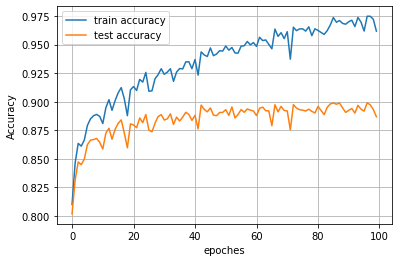

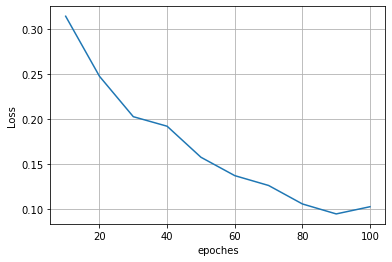

In [ ]:
# Initial training
mlp = MLP((784, 256, 10), (RELU, Softmax))
train_log, val_log = mlp.fit(x_train, y_train, x_test, y_test, p_epoches=100, p_batchsize=256, loss=CE,lambd = 0, learning_rate=1e-1, plot=True)

### MLP with 2 hidden layer (RELU, RELU | 64 Units)

Epoch 79
Train accuracy: 0.89825
Test accuracy: 0.8676


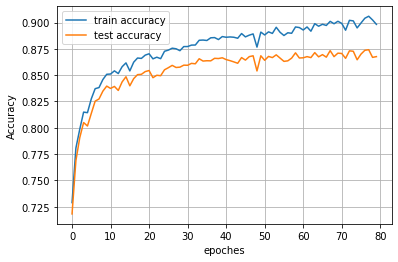

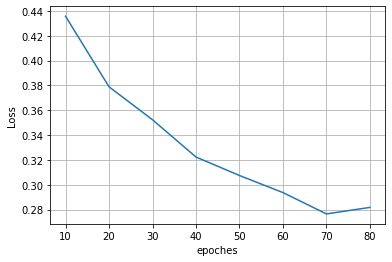

In [ ]:
nn = MLP((784, 64, 64, 10), (RELU, RELU, Softmax))
train_log, val_log = nn.fit(x_train, y_train, x_test, y_test, p_epoches=80, p_batchsize=256, loss=CE,lambd = 0, learning_rate=1e-2, plot=True)

### MLP with 2 hidden layer (RELU, RELU | 256 Units)

Epoch 79
Train accuracy: 0.9175833333333333
Test accuracy: 0.8799


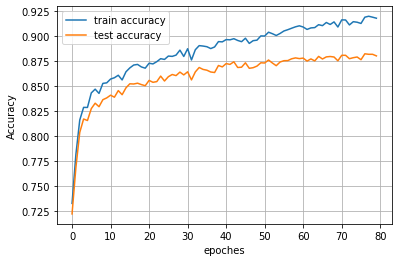

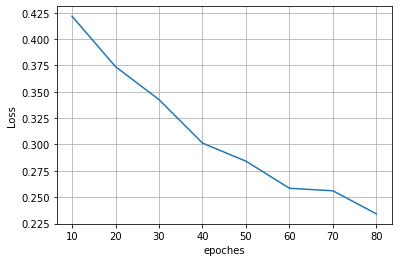

In [ ]:
nn = MLP((784, 256, 256, 10), (RELU, RELU, Softmax))
train_log, val_log = nn.fit(x_train, y_train, x_test, y_test, p_epoches=80, p_batchsize=256, loss=CE,lambd = 0, learning_rate=1e-2, plot=True)

## Tanh Variation

### MLP with 2 hidden layers (Tanh, Tanh | 64 Units)

Epoch 79
Train accuracy: 0.94965
Test accuracy: 0.879


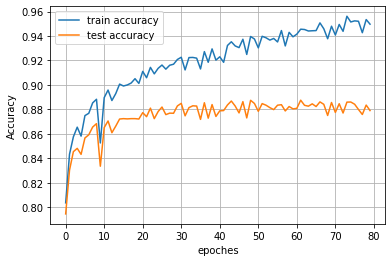

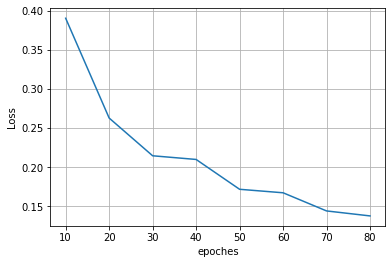

In [ ]:
mlp = MLP((784, 64, 64, 10), (Tanh, Tanh, Softmax))
train_log, val_log = mlp.fit(x_train, y_train, x_test, y_test, p_epoches=80, p_batchsize=256, loss=CE,lambd = 0, learning_rate=1e-1, plot=True)

### MLP with 2 hidden layers (Tanh, Tanh | 256 Units)

Epoch 79
Train accuracy: 0.9725833333333334
Test accuracy: 0.8901


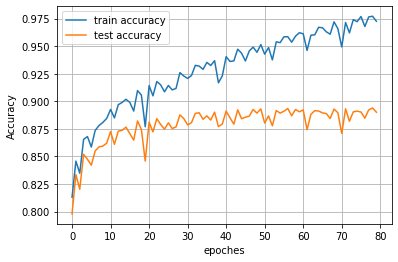

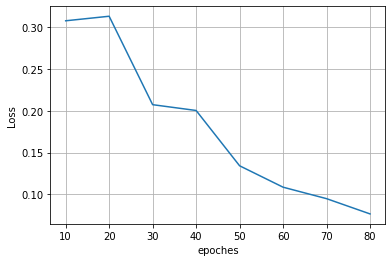

In [ ]:
mlp = MLP((784, 256, 256, 10), (Tanh, Tanh, Softmax))
train_log, val_log = mlp.fit(x_train, y_train, x_test, y_test, p_epoches=80, p_batchsize=256, loss=CE,lambd = 0, learning_rate=1e-1, plot=True)

## Sigmoid Variation

### MLP with 2 hidden layers (Sigmoid, Sigmoid | 64 Units)

Epoch 79
Train accuracy: 0.8445
Test accuracy: 0.8293


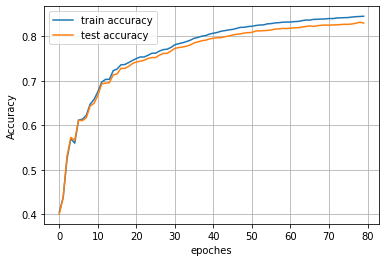

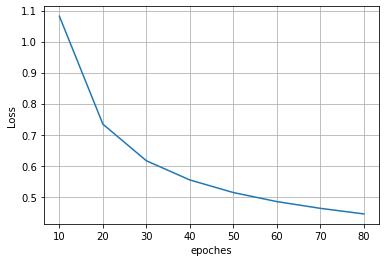

In [ ]:
mlp = MLP((784, 64, 64, 10), (Sigmoid, Sigmoid, Softmax))
train_log, val_log = mlp.fit(x_train, y_train, x_test, y_test, p_epoches=80, p_batchsize=256, loss=CE,lambd = 0, learning_rate=1e-2, plot=True)

### MLP with 2 hidden layers (Sigmoid, Sigmoid | 256 Units)

Epoch 79
Train accuracy: 0.8430666666666666
Test accuracy: 0.83


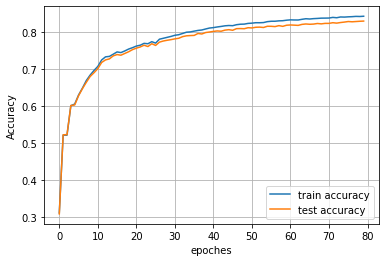

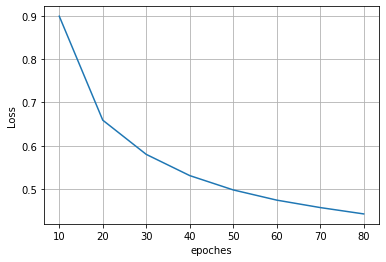

In [ ]:
mlp = MLP((784, 256, 256, 10), (Sigmoid, Sigmoid, Softmax))
train_log, val_log = mlp.fit(x_train, y_train, x_test, y_test, p_epoches=80, p_batchsize=256, loss=CE,lambd = 0, learning_rate=1e-2, plot=True)

## Data Size Variation

In this section, I vary the training dataset size on a 2-layer RELU+RELU 128 unit MLP.

Epoch 79
Train accuracy: 0.8741
Test accuracy: 0.8371


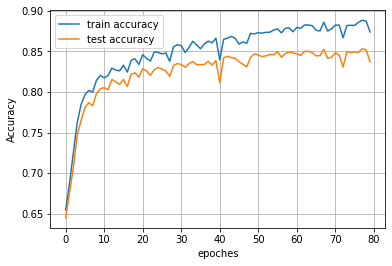

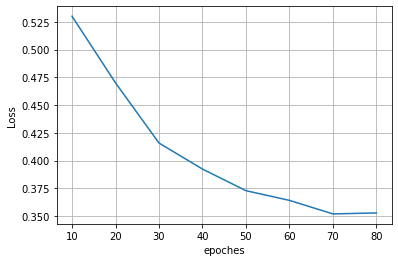

Test accuracy for training size 20000 : 0.8371
Train accuracy for training size 20000 : 0.8586833333333334


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

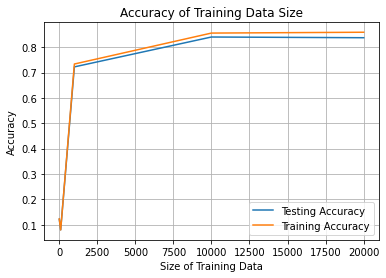

<Figure size 432x288 with 0 Axes>

In [ ]:
N = x_train.shape[0]
train_size = [10, 100, 1000, 10000, 20000]
test_acc = []
train_acc = []

for size in train_size:
  mlp = MLP((784, 128, 128, 10), (RELU, RELU, Softmax))
  train_log, test_log = mlp.fit(x_train[-size:], y_train[-size:], x_test, y_test, p_epoches=80, p_batchsize=256, loss=CE,lambd = 0, learning_rate=1e-2, plot=True)

  acc = evaluate_acc(mlp.predict(x_test), y_test)
  test_acc.append(acc)
  print(f"Test accuracy for training size {size} : {acc}")

  acc_train = evaluate_acc(mlp.predict(x_train), y_train)
  train_acc.append(acc_train)
  print(f"Train accuracy for training size {size} : {acc_train}")

plt.plot(train_size, test_acc, label = "Testing Accuracy")
plt.plot(train_size, train_acc, label = "Training Accuracy")
plt.xlabel("Size of Training Data")
plt.ylabel("Accuracy")
plt.title("Accuracy of Training Data Size")
plt.legend()
plt.grid()
plt.figure()

x_train[-size:]

In [ ]:
for i in range(len(train_size)):
  print(f"Training Size: {train_size[i]} => Train Accuracy: {train_acc[i]}, Test Accuracy: {test_acc[i]}")

Training Size: 10 => Train Accuracy: 0.12278333333333333, Test Accuracy: 0.1221
Training Size: 100 => Train Accuracy: 0.07981666666666666, Test Accuracy: 0.0801
Training Size: 1000 => Train Accuracy: 0.7334833333333334, Test Accuracy: 0.7222
Training Size: 10000 => Train Accuracy: 0.8554, Test Accuracy: 0.8399
Training Size: 20000 => Train Accuracy: 0.8586833333333334, Test Accuracy: 0.8371
